# Lorenzo Pastore - Big Data in GIS (Task 2)
Matricola: 847212

Answer the following question: 
1. What is the difference in average of the mean temperature anomaly for the last 30 years of the record compared to that of the first three decades of the twentieth century?
2. Is this difference statistically significant?

In [2]:
#Import libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime as dtm
from datetime import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## Dataset acquisition, exploration and preprocessing

In [4]:
#Creazione df metadati
metadata = pd.DataFrame(columns=['ID','stname','country','elev','lat','lon'])

#Creazione df serie storiche
time_axis = pd.date_range('1850-01','2019-01',freq='M')
nmonths=len(time_axis)
nyears=nmonths/12

data0 = pd.DataFrame({'time':time_axis})
data0 = data0.set_index(['time'])

In [7]:
#-------------------------------------------------
#-- get info on database and files organization --
#-------------------------------------------------

flist = [os.path.join(path, name) for path, subdirs, files in os.walk("./CRUTEM.4.6.0.0.station_files/") for name in files]
for i in range(0,5):
  print (flist[i])

# exclude first 2 items, not relevant
flist=flist[2:]
print ('\n',flist[0:5])

nst=len(flist)
print ("\n > Number of stations = ",nst)

# Dataset acquisition

nst_tmp = 10295 

#- set counters for diagnostics 
nodatacount=0  
tooshortcount=0 
outsidecount=0

from tqdm import tqdm
for si in tqdm(range(0,nst_tmp)):

  #- open file 
  
  filein=flist[si]

  with open(filein) as f: data = f.readlines()
  skipi = data.index("Obs:\n")+1
  if (len(data)-skipi < 2):
    nodatacount+=1    
    continue

  yr = np.genfromtxt(filein, skip_header=skipi, delimiter=None, usecols=0, dtype='i4')
  nyr = len(yr)

  if (nyr < 30):
    tooshortcount+=1 
    continue  

  norm_line = [line for line in data if "Normals=" in line]
  norm = str(norm_line).split("=",1)[1]
  norm  = norm[:-4].strip() 
  if (norm.find("-99.0") > -1):   
    outsidecount+=1 
    continue   

  stname_line = [line for line in data if "Name=" in line]
  stname = str(stname_line).split("=",1)[1]
  stname  = stname[:-4].strip()    
    
  country_line = [line for line in data if "Country=" in line]
  country = str(country_line).split("=",1)[1]
  country  = country[:-4].strip() 

  elev_line = [line for line in data if "Height=" in line]
  elev = str(elev_line).split("=",1)[1] 
  elev = float(elev[:-4].strip())

  lat_line = [line for line in data if "Lat=" in line]
  lat = str(lat_line).split("=",1)[1] 
  lat = float(lat[:-4].strip())

  lon_line = [line for line in data if "Long=" in line]
  lon = str(lon_line).split("=",1)[1] 
  lon = float(lon[:-4].strip())      

  # Append local values to metadata df
    
  metadata = metadata.append({
     "ID": filein[-6:],
     "stname": stname,
     "country": country,
     "elev": elev,
     "lat":  lat,      
     "lon":  lon,
     }, ignore_index=True)

  ti0 = datetime.strptime(str(yr[0]), "%Y")
  ti1 = datetime.strptime(str(yr[nyr-1]+1), "%Y")
  stime = pd.date_range(ti0, ti1, freq='M')     
  if ((yr[nyr-1]-yr[0]+1) != len(yr)):  # check if data of any year are missing within the first and last year
    print('WARNING: station {} has missing years !'.format(metadata0.ID[si]))

  loc_data_2d = np.genfromtxt(filein, skip_header=skipi, filling_values='-99.0', delimiter=None, dtype='float')[:,1:13]  #[rows,cols]
  loc_data_1d = loc_data_2d.flatten()
  
  xdf = pd.DataFrame({'time': stime, filein[-6:]: np.asarray(loc_data_1d)})
  xdf = xdf.set_index('time')
  

  data0 = pd.merge(data0, xdf, on='time', how='left')

  0%|          | 4/10295 [00:00<04:18, 39.86it/s]

./CRUTEM.4.6.0.0.station_files/.DS_Store
./CRUTEM.4.6.0.0.station_files/Index
./CRUTEM.4.6.0.0.station_files/61/616120
./CRUTEM.4.6.0.0.station_files/61/612913
./CRUTEM.4.6.0.0.station_files/61/612770

 ['./CRUTEM.4.6.0.0.station_files/61/616120', './CRUTEM.4.6.0.0.station_files/61/612913', './CRUTEM.4.6.0.0.station_files/61/612770', './CRUTEM.4.6.0.0.station_files/61/614010', './CRUTEM.4.6.0.0.station_files/61/618470']

 > Number of stations =  10295


100%|██████████| 10295/10295 [07:47<00:00, 22.02it/s]


In [8]:
# Print some info

print(nodatacount,'stations with no data (not acquired)')
print(tooshortcount,'stations with too little data (not acquired)')
print(outsidecount,'stations with not enough data for the ref. period (not acquired)')
print("{} [{}] valid stations acquired".format(nst_tmp-nodatacount-tooshortcount-outsidecount,len(metadata.ID)))

13 stations with no data (not acquired)
2152 stations with too little data (not acquired)
673 stations with not enough data for the ref. period (not acquired)
7457 [7457] valid stations acquired


In [9]:
# Convert all missing values (-99.0) into NAN
data0[data0 == -99.0] = np.nan
# Take station IDs as index for metadata0
metadata = metadata.set_index(['ID'])
# Fix longitudes
metadata.lon = -metadata.lon

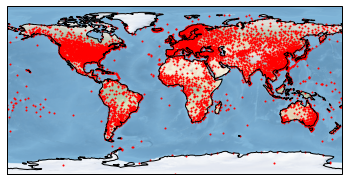

In [10]:
# Plot stations in our dataset

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
ax.scatter([metadata.lon],[metadata.lat],color='r',marker='o',s=1.0)
plt.show()

## Create data anomalies

In [11]:
# First, let's identify the position along the time index that corresponds to the begining/end of the reference period

x1=data0.index.get_loc('1961-01-31')
x2=data0.index.get_loc('1990-12-31')

# Then calculate the "Normals"

data_normals = data0[x1:x2].groupby(data0[x1:x2].index.month).mean()

# Make a copy of data0 (data_anom) to store the anomalies

data_anom = data0

# Then loop through all the years (January) in the time axis, and substract the Normals from each chunk of 12 

y0 = 0
for yi in tqdm(range(0,int(nyears))):
    data_anom.iloc[y0:y0+12,:] = data0.iloc[y0:y0+12,:]- np.array(data_normals.iloc[:,:])
    y0+=12

100%|██████████| 169/169 [00:00<00:00, 280.69it/s]


In [12]:
#create grid

resol = 20 #5 #degrees (E and N)
nlon = np.int(360/resol)
nlat = np.int(180/resol)

#define grid cells margins
grlons = np.empty([nlon+1],dtype='float')
grlats = np.empty([nlat+1],dtype='float')
grlons[0]= -180.
grlats[0]= -90.
for i in range(1,nlon+1):
    grlons[i]=grlons[i-1]+resol
for i in range(1,nlat+1):
    grlats[i]=grlats[i-1]+resol

In [13]:
# Create data structure to host the gridden dataset:

data_mo = np.empty([nmonths,nlat,nlon],dtype='float')
data_mo[:,:,:]=np.nan

data_yr = np.empty([int(nyears),nlat,nlon],dtype='float')
data_yr[:,:,:] = np.nan

In [14]:
# Iterate over grid cells and 
# - get the average time series of all stations in grid cells at monthly resolution and integrate to annual resolution

for j in range(0,nlat):
    for i in range(0,nlon):
        
        dummy = metadata[metadata.lon >= grlons[i]]
        dummy = dummy[dummy.lon < grlons[i+1]]
        dummy = dummy[dummy.lat >= grlats[j]]
        dummy = dummy[dummy.lat < grlats[j+1]]
        
        #print('*',grlons[i],grlons[i+1],grlats[j],grlats[j+1])
        #print(dummy.index)
        
        if (len(dummy.index)>0):
            
            # calculation
            
            data_mo[:,j,i] = np.array(data_anom[dummy.index].mean(axis=1)).flatten()
            
            data_yr[:,j,i] = np.array(data_anom[dummy.index].mean(axis=1).resample("Y").mean()).flatten()

# Task 2

Showing the station map, the global average temperature and the variation for each year between the 1900/1931 and the 1970/2001


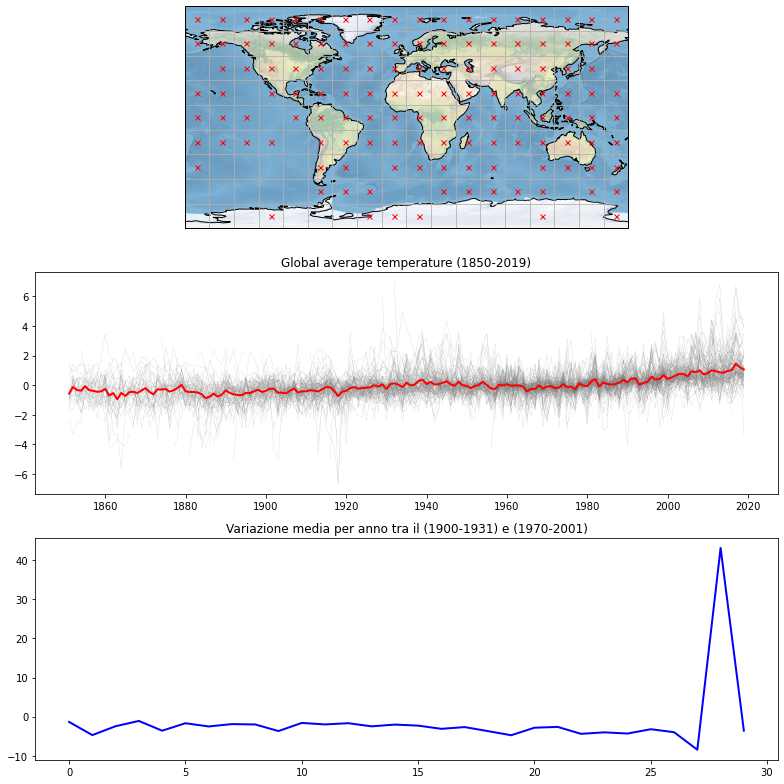

In [21]:
# Prepare to display to check things

fig = plt.figure(figsize=(11,11))
#subplots = (2,3)
grid = plt.GridSpec(3,1)

ax = fig.add_subplot(grid[0,:],projection=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.gridlines(xlocs=range(-180,181,resol), ylocs=range(-90,91,resol))

tser = fig.add_subplot(grid[1,:])

# Initialize data structure to host global average temperature anomaly time series

data_glob = np.empty([int(nyears)],dtype=float)
data_glob[:] = np.nan

# Loop over all grid cells

for j in range(0,nlat):
    for i in range(0,nlon):
        
        # Check if current grid cell has an associated time series
        
        if not(np.isnan(data_yr[:,j,i]).all()):
            
            # place a marker on the map, and plot individual grid cell time series
            
            ax.plot(grlons[i:i+2].sum()/2, grlats[j:j+2].sum()/2,
                color='red', marker='x', markersize=5, transform=ccrs.PlateCarree())
            plt.plot(pd.date_range('1850-01','2019-01', freq='Y'),data_yr[:,j,i],color='gray',linewidth=0.1)
            
# Calculate the global average at each time step

for t in range(0,int(nyears)):
    
        local = data_yr[t,:,:]
        valid = np.isnan(data_yr[t,:,:])
        data_glob[t] = np.nanmean(local[~valid]) #*sin(radians(grlats[j:j+2].sum()/2))

# plot the global average curve

tser.set_title('Global average temperature (1850-2019)')
plt.plot(pd.date_range('1850-01','2019-01', freq='Y'),data_glob[:],color='red',linewidth=2)

diff = fig.add_subplot(grid[2,:])
diff.set_title('Variazione media per anno tra il (1900-1931) e (1970-2001)')
data_diff = (data_glob[139:]-data_glob[:30])/data_glob[:30]
plt.plot(data_diff,color='blue',linewidth=2)

fig.tight_layout()
plt.show()

### What is the difference in average of the mean temperature anomaly for the last 30 years of the record compared to that of the first three decades of the twentieth century?

The average difference between the global mean temperature of 1900-1931 and 1970-200: **1.100**

In [16]:
data_diff = (data_glob[139:]-data_glob[:30])#/data_glob[:30]

print('Differenza media tra la temperatura media globale nel periodo 1900-1931 e 1970-2001:', data_diff.mean())

Differenza media tra la temperatura media globale nel periodo 1900-1931 e 1970-2001: 1.1001506783277142


W-test, p-value: (0.9625681042671204, 0.35969191789627075)


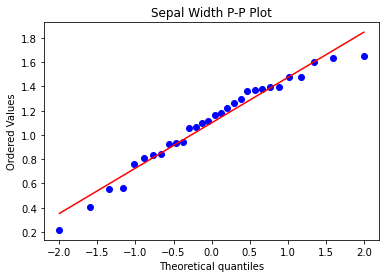

In [20]:
# Two different methods of conducting a t-test
from scipy import stats

#normal distributions check
stats.probplot(data_diff, plot= plt)
plt.title('Sepal Width P-P Plot')

#Shapiro normality test
print('W-test, p-value:',stats.shapiro(data_diff))

### Is this difference statistically significant?


According to the Student t test the hypotesis that the two means are equal is rejected, there is no empiric evidence that the means are equal either with a 90%, 95% or 99% degree of confidence.
**Hence it is possible to assume that the means have a statistically significant difference**

In [22]:
#Independent t-test using scipy.stats

data1 = data_glob[139:]
data2 = data_glob[:30]

print('The null hypothesis is that 2 independent samples have identical average')
stats.ttest_ind(data2, data1)

The null hypothesis is that 2 independent samples have identical average


Ttest_indResult(statistic=-15.558049982147832, pvalue=2.3118192938118185e-22)